In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
# Load Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels (already numerical)

In [3]:
# Convert to DataFrame for easy inspection
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

In [4]:
# Display first and last 5 rows
print("First 5 rows of dataset:\n", df.head())
print("\nLast 5 rows of dataset:\n", df.tail())

First 5 rows of dataset:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Last 5 rows of dataset:
      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [8]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [9]:
# Define Neural Network Model
class IrisClassifier(nn.Module):
    def __init__(self, input_size,h1, h2, output_size):
        super(IrisClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

In [11]:
input_size = X_train.shape[1]
output_size = len(iris.target_names)
h1 = 10
h2 = 11

In [12]:
# Initialize model, loss function, and optimizer
model = IrisClassifier(input_size=input_size, h1=10, h2=11, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=100)

Epoch [10/100], Loss: 0.1514
Epoch [20/100], Loss: 0.0033
Epoch [30/100], Loss: 0.1024
Epoch [40/100], Loss: 0.0056
Epoch [50/100], Loss: 0.0018
Epoch [60/100], Loss: 0.0035
Epoch [70/100], Loss: 0.0126
Epoch [80/100], Loss: 0.0234
Epoch [90/100], Loss: 0.0673
Epoch [100/100], Loss: 0.0004


In [14]:
# Evaluate the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())


Name: 
Register No: 
Test Accuracy: 0.97%
Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  1 10]]
Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      1.00      0.95         9
   virginica       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



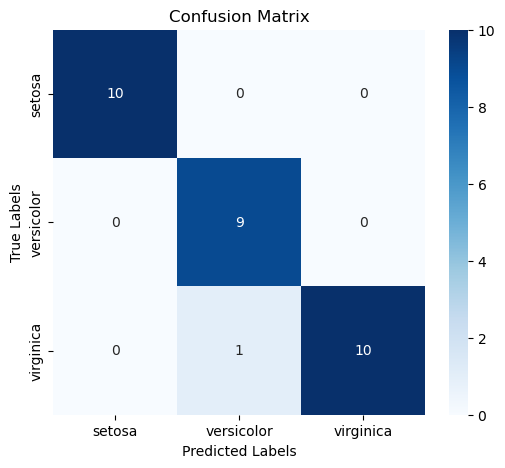

In [15]:
# Compute metrics
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=iris.target_names)

# Print details
print("\nName: ")
print("Register No: ")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names, fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Make a sample prediction
sample_input = X_test[5].unsqueeze(0)  # Removed unnecessary .clone()
with torch.no_grad():
    output = model(sample_input)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = iris.target_names[predicted_class_index]

print("\nName: ")
print("Register No: ")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {iris.target_names[y_test[5].item()]}')


Name: 
Register No: 
Predicted class for sample input: setosa
Actual class for sample input: setosa
